In [2]:
import sys
print(sys.prefix)
print(sys.executable)

/home/isa/cruciblelabs/subnet-MoE/.venv
/home/isa/cruciblelabs/subnet-MoE/.venv/bin/python


## Tax comparison 

/tmp/ipykernel_31081/4186715175.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


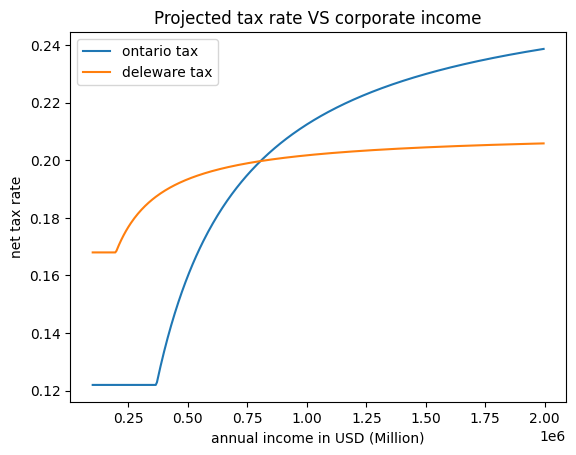

In [5]:
def ont_tax(income):
    SBD_limit = 500_000
    reg_tax = 0.15 +0.115
    SBD_tax = 0.09 + 0.032 
    SBD = min(income, 500_000)
    outside_SBD = max(0, income - SBD)
    return SBD * SBD_tax + outside_SBD * reg_tax

def del_tax(income):
    lower_th = 197_300
    higher_th = 247_300
    reg_tax = 0.21

    lower_th_income = min(lower_th, income)
    outside_th_income = max(0, income - lower_th_income)

    taxable_income = lower_th_income * 0.8 + outside_th_income 
    return taxable_income * reg_tax

import pandas as pd
import matplotlib.pyplot as plt
tax_sim = {}
for i in range(100_000, 2_000_000, 5_000):
    tax_sim[i] = {'ont': ont_tax(i * 1.36) / (i * 1.36), 'del': del_tax(i) / i}     

df = pd.DataFrame(tax_sim)
plt.plot(df.T)
plt.legend()

plt.ylabel('net tax rate')
plt.xlabel('annual income in USD (Million)')
plt.title('Projected tax rate VS corporate income')
plt.legend(['ontario tax', 'deleware tax'])

## Expected income

In [7]:
emission = 0.03
sn_owner_holding = 0.25
alpha_price = 0.03
tao_price = 350

daily_alpha =  7200 * sn_owner_holding
daily_income_USD = alpha_price * daily_alpha * tao_price
yearly_income_USD = daily_income_USD * 365 

print(f"Expected yearly income {yearly_income_USD / 1e6:.2f} Million USD")

Expected yearly income 6.90 Million USD


## bittensor metagraph check 

In [1]:
import json

import os
import re
import json
import pandas as pd
# import plotly.express as px
from itertools import chain


def get_subnetinfo_files(path):

    # Regex to match: subnetinfo_6968000.json
    pattern = re.compile(r"subnetinfo_(\d+)\.json$")
    subnet_infos = {}
    for filename in os.listdir(path):
        match = pattern.match(filename)
        if not match:
            continue  # skip unrelated files

        block = int(match.group(1))
        filepath = os.path.join(path, filename)

        # Example: read the JSON
        with open(filepath, "r") as f:
            data = json.load(f)

        subnet_infos[block] = data

    for block, subnet_info in subnet_infos.items():
        for s in subnet_info:
            s['block'] = block

    subnet_infos = list(chain.from_iterable(subnet_infos.values()))
    subnet_infos=pd.DataFrame(subnet_infos)
    return subnet_infos

subnet_infos = get_subnetinfo_files("/home/isa/cruciblelabs/subnet-MoE/bittensor_subnetinfo_daily/")

In [15]:
interested_netuid = [64, 120, 51, 4]

In [16]:
subnet_infos['tao_per_alpha_out'] = subnet_infos.tao_in / subnet_infos.alpha_out

subnet_infos = subnet_infos.sort_values('block')

px.line(
    subnet_infos[(subnet_infos.tao_per_alpha_out <= 1) & subnet_infos.netuid.isin(interested_netuid)],
    y = 'tao_per_alpha_out',
    x = 'block',
    color='netuid',
    height=600,
    title='tao_per_alpha_out'
)

In [31]:
subnet_infos['risk'] = (subnet_infos.price) / (subnet_infos.tao_per_alpha_out)

subnet_infos = subnet_infos.sort_values('block')

px.line(
    subnet_infos[(subnet_infos.risk <= 2) & subnet_infos.netuid.isin(interested_netuid)],
    y = 'risk',
    x = 'block',
    color='netuid',
    height=600,
    title='tao_per_alpha_out_trend',
)

In [ ]:
_subnet_infos = subnet_infos[subnet_infos.netuid == 120]
_subnet_infos.alpha_out[_subnet_infos.alpha_out_emission != 1]

4724     0.0
21718    0.0
29444    0.0
2926     0.0
6937     0.0
25756    0.0
378      0.0
14166    0.0
28130    0.0
12682    0.0
11299    0.0
5220     0.0
11044    0.0
28479    0.0
29316    0.0
18231    0.0
27743    0.0
120      0.0
3497     0.0
16739    0.0
24069    0.0
15296    0.0
6348     0.0
10374    0.0
11779    0.0
17276    0.0
14419    0.0
17018    0.0
16042    0.0
8369     0.0
28828    0.0
10915    0.0
16171    0.0
8611     0.0
27614    0.0
10786    0.0
26441    0.0
26183    0.0
2668     0.0
19177    0.0
27009    0.0
17405    0.0
31219    0.0
21968    0.0
23612    0.0
18720    0.0
12037    0.0
9096     0.0
9483     0.0
15784    0.0
5961     0.0
20063    0.0
Name: alpha_out_emission, dtype: float64

## Calculating miner cost

In [3]:
GPU_hours = 3520
completion_days = 30 
a6000_rental_cost = 0.56
tao_price = 350

required_miners = GPU_hours / 24 / completion_days
top_n_take_most = required_miners * 0.8 
miner_cost_per_month_USD = required_miners * 24 * 30 * 0.56
miner_cost_per_month_TAO = miner_cost_per_month_USD / tao_price
miner_alphas_per_month = 7200 * 0.41 * completion_days
minimum_alpha_price = miner_cost_per_month_TAO / miner_alphas_per_month
minimum_alpha_price, miner_cost_per_month_TAO

(6.359530261969287e-05, 5.632000000000001)

## Calculate inflow

In [29]:
import plotly.express as px
import bittensor as bt 

sub = bt.subtensor(network = "wss://archive.cruciblelabs.com:9944")

In [31]:
alpha = 0.000003209
alpha = 1 - (1-alpha)**(7200)

subnet_infos = get_subnetinfo_files("/home/isa/cruciblelabs/subnet-MoE/bittensor_subnetinfo_daily/")
subnet_infos_temp = subnet_infos.copy()
subnet_infos = []
for netuid in subnet_infos_temp.netuid.unique():
    _subnet_infos = subnet_infos_temp[subnet_infos_temp.netuid == netuid]
    _subnet_infos = _subnet_infos.sort_values('block')

    _subnet_infos['inflow'] = _subnet_infos.tao_in - _subnet_infos.tao_in.shift() - _subnet_infos.tao_in_emission * 7200

    _subnet_infos = _subnet_infos[_subnet_infos.block > sub.block - 7200 * 30]
    _subnet_infos['inflow_ema'] = _subnet_infos.inflow.ewm(alpha = alpha).mean()
    subnet_infos.append(_subnet_infos)

subnet_infos = pd.concat(subnet_infos)

In [34]:
interested_netuid = [64, 120, 51, 4, 8, 3, 62, 9, 34, 121]
px.line(
    subnet_infos[subnet_infos.netuid.isin(interested_netuid)],
    'block',
    'inflow_ema',
    color = 'netuid',
    range_x = [6.8e6, subnet_infos.block.max()],
    range_y = [-5e3, 5e3],
    height = 600,
    width = 1000,
    title = 'Inflow simulation'
)

In [94]:
daily_mining_cost_USD

249.60000000000002

In [168]:
# 1% emission -> daily inflow 15 tao
from pool import Pool

# emission per day
emission = 0.01
base_tao_inflow = 15
issued_tao = 10.4e6
alpha_out_emission = 7200 
p = Pool(netuid = 0, tao_in = 0.01, alpha_in = 1, alpha_out = 0)

# mining cost 
expert_groups = 4
miners_per_group = 7
num_miners = expert_groups * miners_per_group
cost_per_miner = 0.52 * 24
daily_mining_cost_USD = num_miners * cost_per_miner
tao_price = 350 

df = []
total_tao_invested = 0
total_tao_auto_sell = 0
for day in range(365): 

    tao_in_emission = 7200 * 0.5 * emission
    alpha_in_emission = tao_in_emission / p.price

    # emission
    p.inject(tao_in_emission, alpha_in_emission, alpha_out_emission)
    
    # auto sell
    issued_tao += 7200
    root_tao = issued_tao * 0.5
    alpha = p.alpha_in + p.alpha_out
    root_prop = root_tao * 0.18 / (root_tao * 0.18 + alpha)
    auto_sell_tao = p.sell(alpha_out_emission * 0.41 * root_prop)
    total_tao_auto_sell += auto_sell_tao

    # inflow 
    tao_inflow = min(day * 5 / 365, 1) * base_tao_inflow
    # tao_inflow = base_tao_inflow
    p.buy(tao_inflow)
    total_tao_invested += tao_inflow

    # miner sell 
    miner_sell_tao = p.sell(daily_mining_cost_USD / tao_price / p.price)    
    
    df.append({
        'tao_inflow': tao_inflow,
        'total_tao_invested': total_tao_invested,
        'net_tao_flow': tao_inflow - miner_sell_tao - auto_sell_tao,
        'alpha_in_emission': alpha_in_emission,
        'tao_in': p.tao_in,
        'alpha_in': p.alpha_in,
        'alpha_out': p.alpha_out,
        'tao_in/alpha_out': p.tao_in / p.alpha_out,

        'price': p.price,
        'day': day,
        'root_prop': root_prop,
        
        'miner_sell_tao': miner_sell_tao,
        'auto_sell_tao': auto_sell_tao, 
        'total_tao_auto_sell': total_tao_auto_sell
    })

df = pd.DataFrame(df)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

cols = df.columns
rows = math.ceil(len(cols) / 3)

fig = make_subplots(
    rows=rows,
    cols=3,
    shared_xaxes=True,
    subplot_titles=cols,  # adds titles above each subplot
    vertical_spacing=0.03   # <<< reduce space between plots
)

for i, col in enumerate(cols):
    r = i // 3 + 1
    c = i % 3 + 1

    fig.add_trace(
        go.Scatter(x=df.index, y=df[col], mode='lines', name=col),
        row=r, col=c
    )

    # Add Y-axis label for each subplot
    fig.update_yaxes(title_text=col, row=r, col=c)

# Add one global X-axis label (cleaner)
fig.update_xaxes(title_text="Index / Time", row=rows, col=1)
fig.update_xaxes(title_text="Index / Time", row=rows, col=2)

fig.update_layout(
    height=350 * rows,
    title="Grid of Subplots with Axis Titles",
    margin=dict(
        t=40,  # top
        b=40,  # bottom
        l=50,  # left
        r=20   # right
    )
)

fig.show()
